# Global Temperature Anomaly: Time Series Modeling
#### Lucas Dwyer

### Problem Statement:

### Imports

In [379]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, register_matplotlib_converters
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
register_matplotlib_converters()

### Function Definitions

In [380]:
def evaluate_model(model, X, y):
    y_train_hat = model.predict(X)
    # give me the r2, mse, and rmse for our training split
    print(f'R2 Score: {r2_score(y, y_train_hat)}')
    print(f'MSE: {mean_squared_error(y, y_train_hat)}')
    print(f'RMSE: {mean_squared_error(y, y_train_hat)**0.5}')
    
def heatmap(df,m,n, drop=[]):
    plt.figure(figsize = (n,m))

    # Get correlation of variables.

    corr = df.drop(columns=drop,axis=1).corr()

    # Set up mask to be "True" in the upper triangle.
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    # Plot our correlation heatmap, while masking the upper triangle to be white.
    with sns.axes_style("white"):
        sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5)
        
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Read, Clean, Transform Data

[Global Temperature Anomalies Dataset (NOAA)](https://www.ncdc.noaa.gov/cag/global/time-series/globe/land_ocean/ytd/12/1880-2020/data.csv)<br>
[World Methane Emissions Dataset (World Bank)](http://api.worldbank.org/v2/en/indicator/EN.ATM.METH.KT.CE?downloadformat=csv)<br>
[Global Annual Carbon ppm Historical Dataset (IAC)](ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/mole_fraction_of_carbon_dioxide_in_air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-1-0_gr3-GMNHSH_0000-2014.csv)



In [381]:
year_mole_carbon = pd.read_csv('../data/co2/mole_fraction_of_carbon_dioxide_in_air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-1-0_gr3-GMNHSH_0000-2014.csv')
world = pd.read_csv('../data/meteorological/world.csv',index_col=0)
methane = pd.read_csv('../data/methane/adjusted.csv',index_col=0)
year_mole_carbon = year_mole_carbon[year_mole_carbon['year']>=1970]
world = world.iloc[4:]
world.index= pd.to_datetime(world.index)
year_mole_carbon.index= pd.to_datetime(year_mole_carbon.year,format="%Y")
world['January-December'] = world[' January-December'].astype('float64')
world = world.drop(labels = ' January-December', axis =1)
na_years = [
    'Indicator Code',
    'Indicator Name',
    'Country Code',
    '1960',
    '1961',
    '1962',
    '1963',
    '1964',
    '1965',
    '1966',
    '1967',
    '1968',
    '1969',
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018',
    '2019',]
methane = methane.drop(na_years, axis=1)
methane_trans = methane.transpose()
world.index = world.index.strftime('%Y')
methane_w = methane_trans['World'].dropna()
methane_w.index = pd.to_datetime(methane_w.index)
aggr = pd.DataFrame(methane_w).join(world.loc[world.index > '1969-10-16 08:00:00'])
aggr = aggr.join(year_mole_carbon)
aggr= aggr.drop(['data_mean_nh', 'data_mean_sh','year'],axis=1)
aggr.columns = ['world_methane', 'temp_anomaly','world_carbon']

# EDA

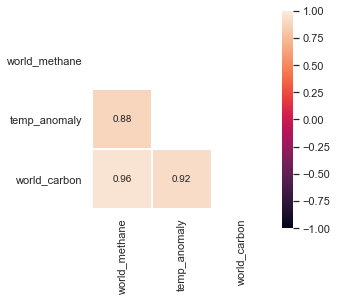

In [382]:
heatmap(aggr,4,4);

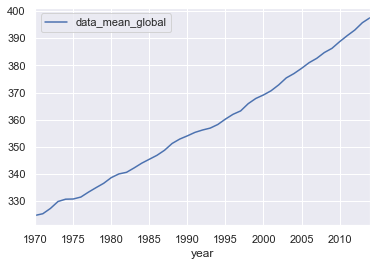

In [383]:
year_mole_carbon[year_mole_carbon['data_mean_global']>=300].plot(y='data_mean_global');

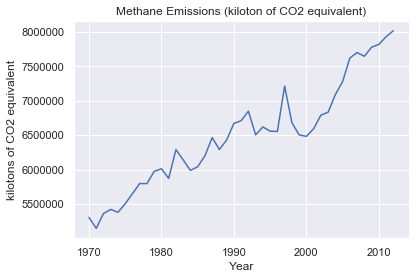

In [384]:
ax = methane_trans['World'].plot();
ax.set_title('Methane Emissions (kiloton of CO2 equivalent)');
ax.set_xlabel('Year')
ax.set_ylabel('kilotons of CO2 equivalent');

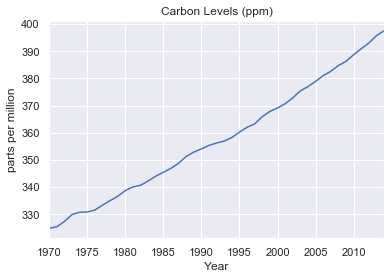

In [385]:
ax = year_mole_carbon[year_mole_carbon['year']>=1970]['data_mean_global'].plot();
ax.set_title('Carbon Levels (ppm)');
ax.set_xlabel('Year')
ax.set_ylabel('parts per million');

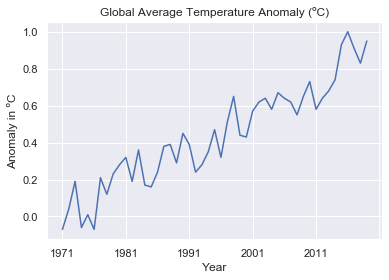

In [386]:
ax = world.loc[world.index > '1970-10-16 08:00:00'].plot();
ax.get_legend().remove()
ax.set_title('Global Average Temperature Anomaly (ºC)');
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly in ºC');

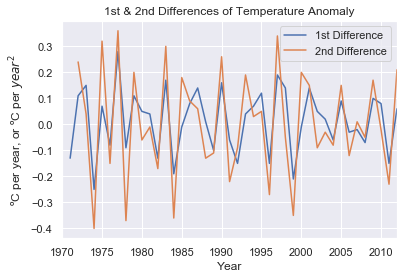

In [387]:
ax1 = aggr['temp_anomaly'].diff(1).plot();
ax2 = aggr['temp_anomaly'].diff(1).diff(1).plot(ax=ax1);
ax1.legend(labels = ['1st Difference', '2nd Difference'])
ax1.set_title('1st & 2nd Differences of Temperature Anomaly');
ax1.set_xlabel('Year')
ax1.set_ylabel('ºC per year, or ºC per $year^2$');

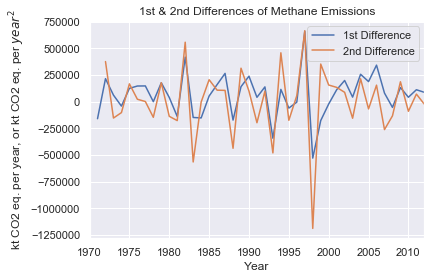

In [388]:
ax1= aggr['world_methane'].diff(1).plot();
ax2= aggr['world_methane'].diff(1).diff(1).plot(ax=ax1);
ax1.legend(labels = ['1st Difference', '2nd Difference'])
ax1.set_title('1st & 2nd Differences of Methane Emissions');
ax1.set_xlabel('Year')
ax1.set_ylabel('kt CO2 eq. per year, or kt CO2 eq. per $year^2$');

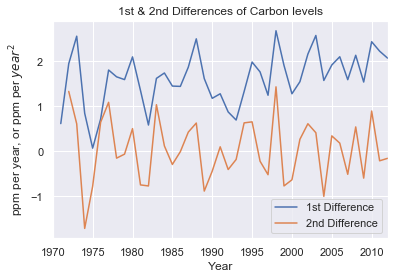

In [389]:
ax1= aggr['world_carbon'].diff(1).plot();
ax2=aggr['world_carbon'].diff(1).diff(1).plot(ax=ax1);
ax1.legend(labels = ['1st Difference', '2nd Difference'])
ax1.set_title('1st & 2nd Differences of Carbon levels');
ax1.set_xlabel('Year')
ax1.set_ylabel('ppm per year, or ppm per $year^2$');

In [390]:

print('Temperature Anomaly:')
print(interpret_dftest(adfuller(aggr['temp_anomaly'])))
print(interpret_dftest(adfuller(aggr['temp_anomaly'].diff(1).dropna())))
print(interpret_dftest(adfuller(aggr['temp_anomaly'].diff(1).diff(1).dropna())))
print('Methane')
print(interpret_dftest(adfuller(aggr['world_methane'])))
print(interpret_dftest(adfuller(aggr['world_methane'].diff(1).dropna())))
print(interpret_dftest(adfuller(aggr['world_methane'].diff(1).diff(1).dropna())))
print('Carbon')
print(interpret_dftest(adfuller(aggr['world_carbon'])))
print(interpret_dftest(adfuller(aggr['world_carbon'].diff(1).dropna())))
print(interpret_dftest(adfuller(aggr['world_carbon'].diff(1).diff(1).dropna())))

Temperature Anomaly:
Test Statistic   -1.480558
p-value           0.543106
dtype: float64
Test Statistic   -4.844346
p-value           0.000045
dtype: float64
Test Statistic   -4.899451
p-value           0.000035
dtype: float64
Methane
Test Statistic   -0.396731
p-value           0.910643
dtype: float64
Test Statistic   -8.172116e+00
p-value           8.567177e-13
dtype: float64
Test Statistic   -6.910237e+00
p-value           1.217669e-09
dtype: float64
Carbon
Test Statistic    2.300048
p-value           0.998955
dtype: float64
Test Statistic   -0.952278
p-value           0.770270
dtype: float64
Test Statistic   -3.837776
p-value           0.002544
dtype: float64


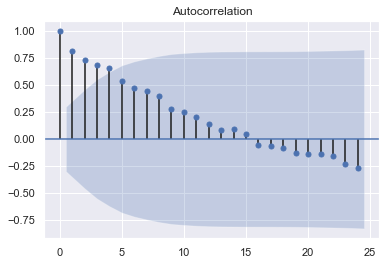

In [391]:
plot_acf(aggr['temp_anomaly'],lags = 24);



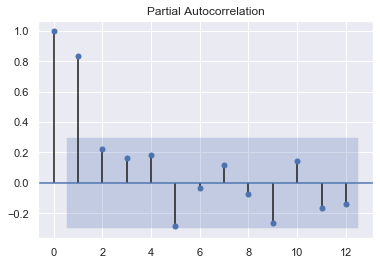

In [392]:
plot_pacf(aggr['temp_anomaly'],lags = 12);

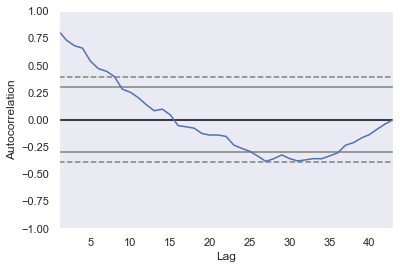

In [393]:
autocorrelation_plot(aggr['temp_anomaly']);

# Feature Engineering


In [394]:
aggr['temp_a_diff_1']= aggr['temp_anomaly'].diff(1)
aggr['target'] = aggr['temp_a_diff_1'].shift(-1)
aggr['temp_a_diff_2']= aggr['temp_anomaly'].diff(1).diff(1)
aggr['world_methane_diff_1']= aggr['world_methane'].diff(1)
aggr['world_methane_diff_2']= aggr['world_methane'].diff(1).diff(1)
aggr['world_carbon_diff_1']= aggr['world_carbon'].diff(1)
aggr['world_carbon_diff_2']= aggr['world_carbon'].diff(1).diff(1)
aggr = aggr.dropna()

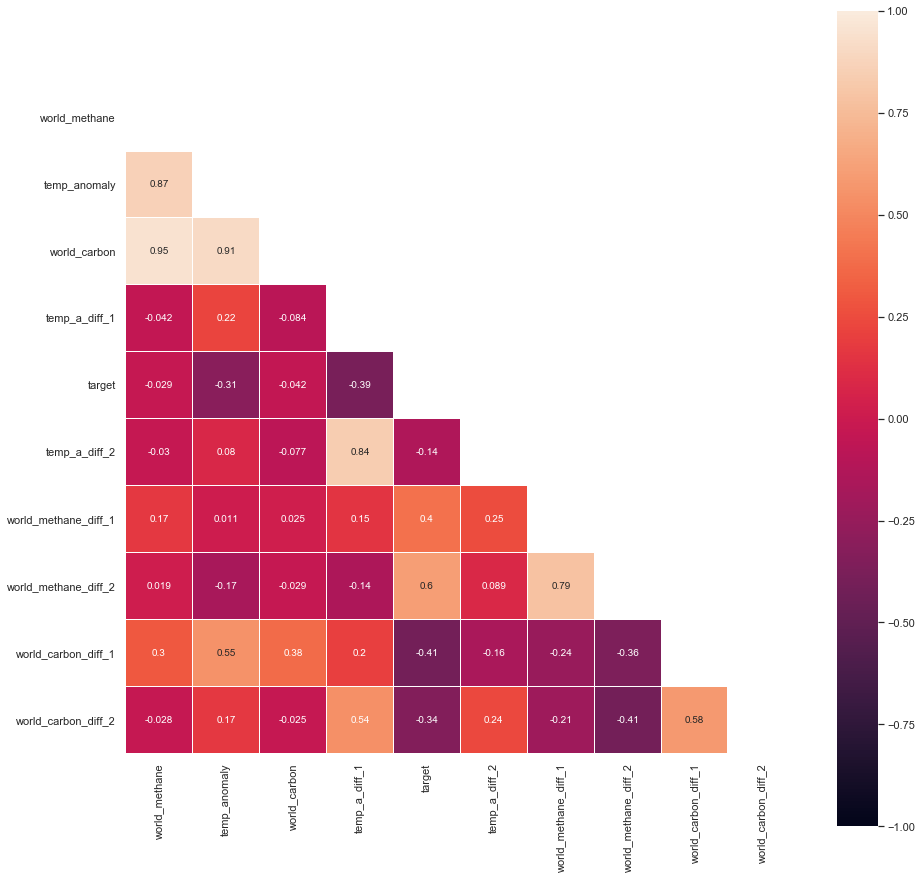

In [395]:
heatmap(aggr,15,15)

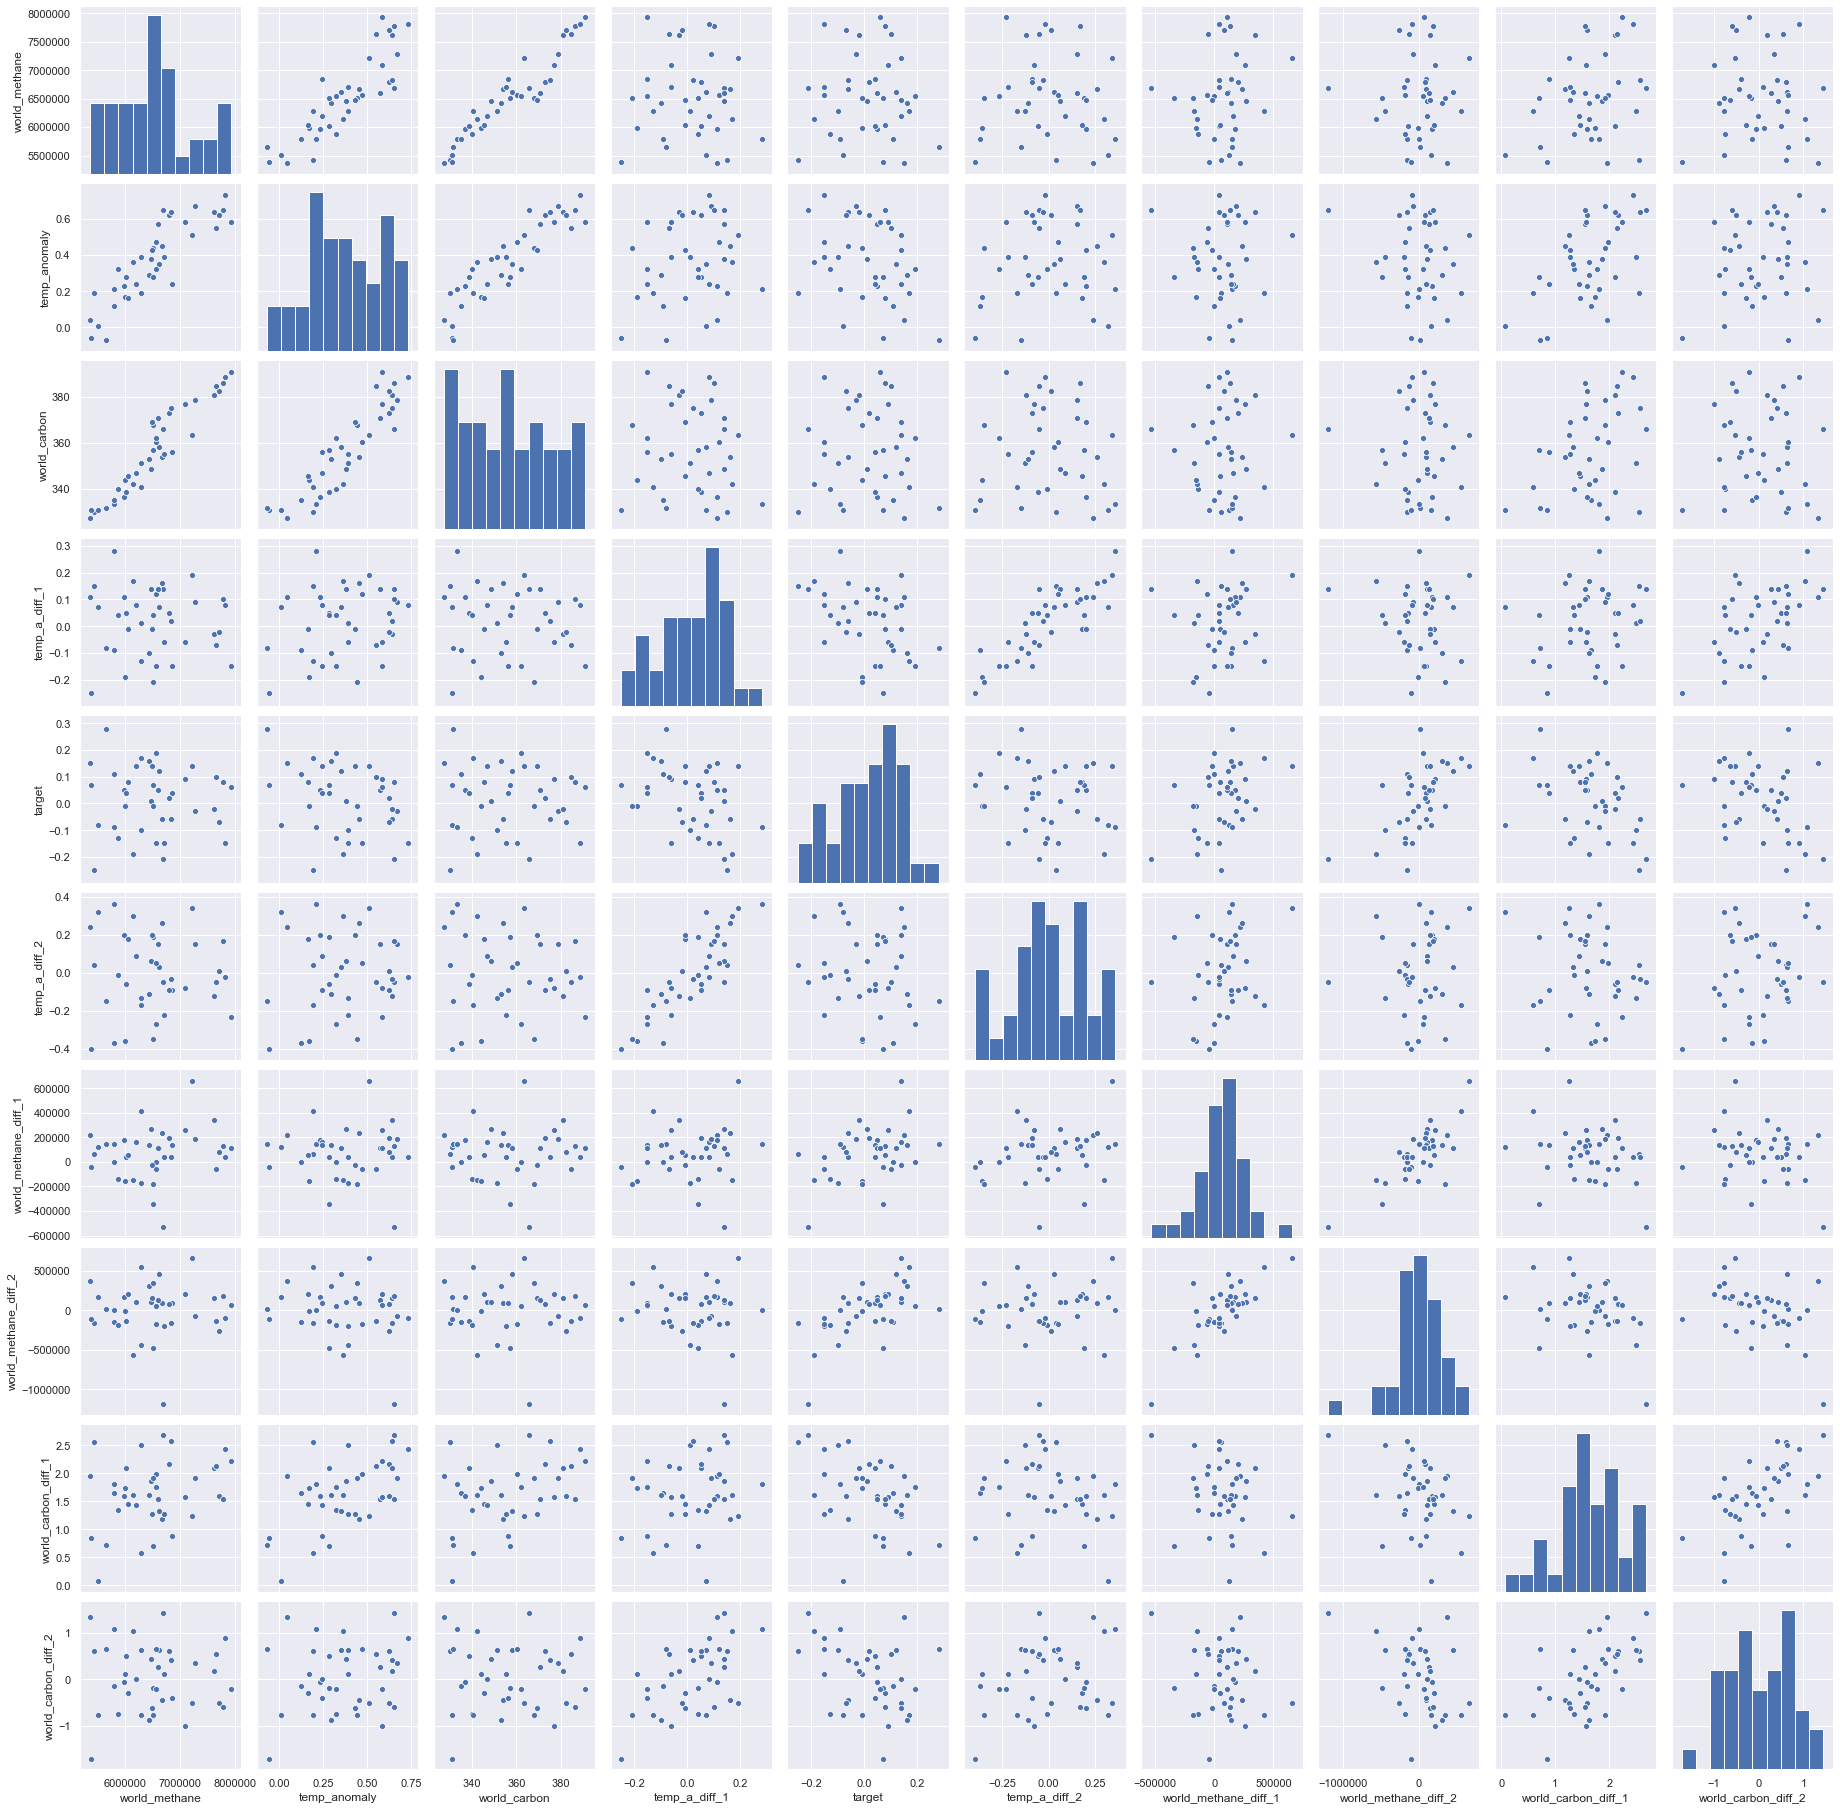

In [396]:
sns.pairplot(aggr);

# Modeling

In [397]:
features = ['world_methane_diff_2', 'world_carbon_diff_2', 'temp_a_diff_1', ]
X= aggr[features]
y= aggr['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, shuffle=False)

In [398]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Ridge Regression

In [399]:
ridge_model = Ridge(alpha=9,fit_intercept=False,solver= 'auto')
ridge_model.fit(X_train_sc, y_train)

print(ridge_model.score(X_train_sc, y_train))
evaluate_model(ridge_model, X_test_sc, y_test)

0.42583481193916173
R2 Score: 0.39245712927676124
MSE: 0.0036914304825144
RMSE: 0.0607571434690144


In [400]:
pred = ridge_model.predict(X_test_sc)

In [401]:
df = pd.DataFrame(y_test)
df['pred'] = pred

In [402]:
residuals_ridge = (y_test) - pred

In [403]:
residuals_ridge.mean()

-0.0017557473639380802

In [404]:
residuals_ridge.sort_values()

2010-01-01   -0.120642
2006-01-01   -0.057164
2007-01-01   -0.034743
2003-01-01   -0.034098
2005-01-01   -0.000547
2011-01-01    0.007041
2002-01-01    0.013177
2004-01-01    0.037981
2009-01-01    0.072287
2008-01-01    0.099150
Name: target, dtype: float64

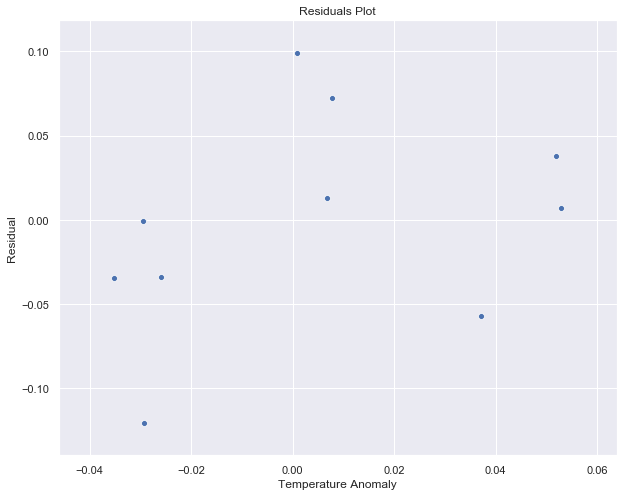

In [405]:
plt.figure(figsize=(10,8))
fig1 = sns.scatterplot(pred, residuals_ridge );
fig1.set(xlabel = 'Temperature Anomaly', ylabel= 'Residual', title = 'Residuals Plot');
sns.set(font_scale=1)

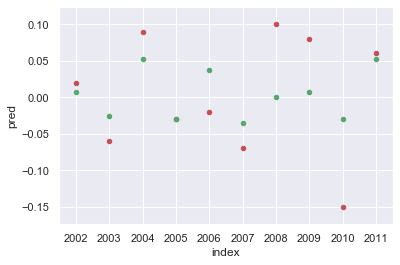

In [406]:

ax1 = df.reset_index().plot(kind='scatter',x='index', y='target', color='r')    
ax2 = df.reset_index().plot(kind='scatter',x='index', y='pred', color='g', ax=ax1) 

### Lasso CV

In [407]:
l_alphas = np.logspace(-3, 0, 100)
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=5000, fit_intercept=False)
lasso_cv.fit(X_train_sc, y_train)
evaluate_model(lasso_cv, X_test_sc, y_test)
pred = lasso_cv.predict(X_test_sc)
df['pred'] = pred

R2 Score: 0.406738706859775
MSE: 0.0036046556171200083
RMSE: 0.06003878427416738


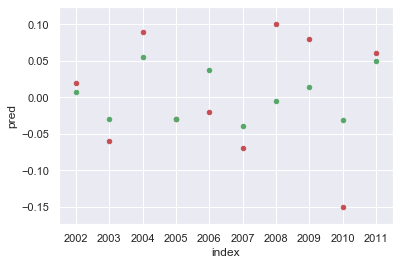

In [408]:
ax1 = df.reset_index().plot(kind='scatter',x='index', y='target', color='r')    
ax2 = df.reset_index().plot(kind='scatter',x='index', y='pred', color='g', ax=ax1) 

In [409]:
residuals_lasso = (y_test) - pred
residuals_lasso.mean()


-0.0010320475783009153

In [410]:
residuals_lasso.sort_values()

2010-01-01   -0.118506
2006-01-01   -0.057994
2003-01-01   -0.030485
2007-01-01   -0.030426
2005-01-01   -0.000236
2011-01-01    0.009649
2002-01-01    0.012468
2004-01-01    0.034283
2009-01-01    0.066068
2008-01-01    0.104859
Name: target, dtype: float64

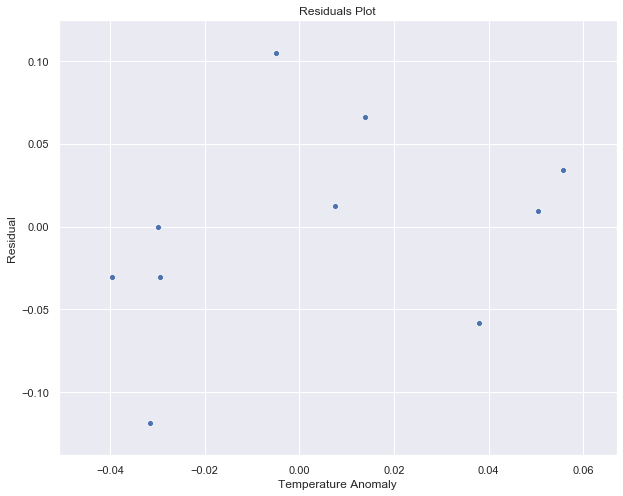

In [411]:

plt.figure(figsize=(10,8))
fig1 = sns.scatterplot(pred, residuals_lasso );
fig1.set(xlabel = 'Temperature Anomaly', ylabel= 'Residual', title = 'Residuals Plot');
sns.set(font_scale=1)

In [412]:
evaluate_model(lasso_cv, X_test_sc, y_test)

R2 Score: 0.406738706859775
MSE: 0.0036046556171200083
RMSE: 0.06003878427416738


In [413]:
evaluate_model(ridge_model, X_test_sc, y_test)

R2 Score: 0.39245712927676124
MSE: 0.0036914304825144
RMSE: 0.0607571434690144


### Statsmodel OLS

In [414]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train.dropna(inplace=True)
y_train = y_train[X_train.index] 

In [415]:

lm = sm.OLS(y_train, X_train)
lm_results = lm.fit()
print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     8.102
Date:                Tue, 08 Sep 2020   Prob (F-statistic):           0.000566
Time:                        10:37:38   Log-Likelihood:                 28.073
No. Observations:                  30   AIC:                            -48.15
Df Residuals:                      26   BIC:                            -42.54
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0247 

In [416]:
olm_results = lm_results.predict(X_test)

In [417]:
evaluate_model(lm_results, X_test,y_test)
ols_reg = y_test - lm_results.predict(X_test)
ols_reg.mean()

R2 Score: 0.22238463652122298
MSE: 0.00472479094849705
RMSE: 0.06873711478158688


-0.024533804678537628

In [418]:
print(abs(ols_reg).sum())
print(abs(residuals_ridge).sum())
print((abs(ols_reg).sum()/abs(residuals_ridge).sum())**-1)

0.5575621705691887
0.47683069456060806
0.8552063244782807


In [419]:
df = aggr

In [420]:
print(interpret_dftest(adfuller(df['world_methane'].diff(1).diff(1).dropna())))
print(interpret_dftest(adfuller(df['world_methane'].diff(1).dropna())))
print(interpret_dftest(adfuller(df['temp_anomaly'].diff(1).dropna())))
print(interpret_dftest(adfuller(df['temp_anomaly'].diff(1).diff(1).dropna())))
print(interpret_dftest(adfuller(df['world_carbon'].diff(1).diff(1).dropna())))

Test Statistic   -6.679441e+00
p-value           4.380015e-09
dtype: float64
Test Statistic   -7.640737e+00
p-value           1.898976e-11
dtype: float64
Test Statistic   -5.046365
p-value           0.000018
dtype: float64
Test Statistic   -4.639639
p-value           0.000109
dtype: float64
Test Statistic   -6.015000e+00
p-value           1.541210e-07
dtype: float64


In [421]:
#df = df[['world_methane_diff_1', 'world_methane_diff_2', 'temp_a_diff_1','temp_a_diff_2', 'world_carbon_diff_2']]
df = df[['world_methane_diff_2', 'world_carbon_diff_2', 'temp_a_diff_1', 'target']]

In [422]:
ss = StandardScaler()
array = ss.fit_transform(df)
array = pd.DataFrame(array)
array.columns = df.columns
array.index = df.index
df_train, df_test = train_test_split(df,
                                     test_size = 0.25,
                                     random_state=42,
                                     shuffle = False)
train, test = train_test_split(array,
                               test_size = 0.25,
                               random_state=42,
                               shuffle = False)

## VAR Model

In [423]:
model = VAR(train)
ts_model = model.fit(maxlags=3, 
                     ic='aic')
print(ts_model.k_ar)
ts_model.summary()

2


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Sep, 2020
Time:                     10:37:38
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -68.7677
Nobs:                     28.0000    HQIC:                  -69.9569
Log likelihood:           863.807    FPE:                2.70219e-31
AIC:                     -70.4806    Det(Omega_mle):     8.86218e-32
--------------------------------------------------------------------
Results for equation world_methane_diff_2
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.086131    109530.002611           -0.000           1.000
L1.world_methane_diff_2        -1.041909         0.276295           -3.771           0.000
L1.wo

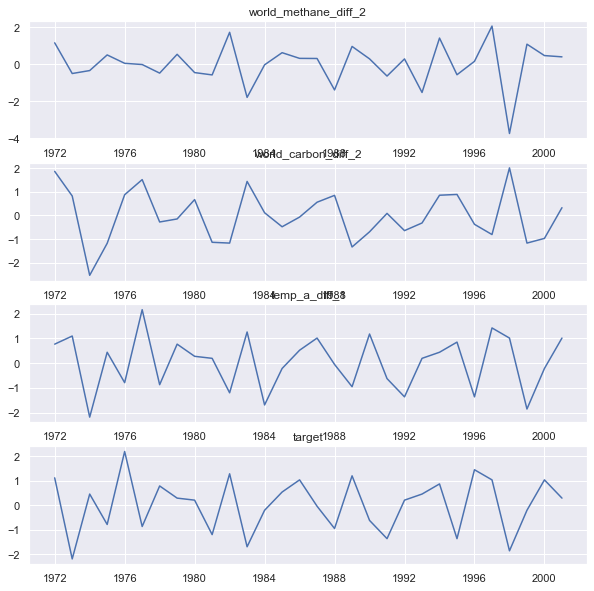

In [424]:

ts_model.plot();

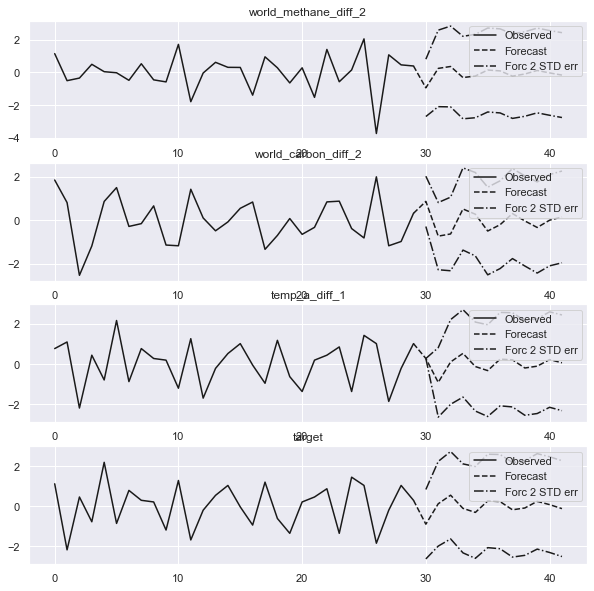

In [425]:
ts_model.plot_forecast(12);

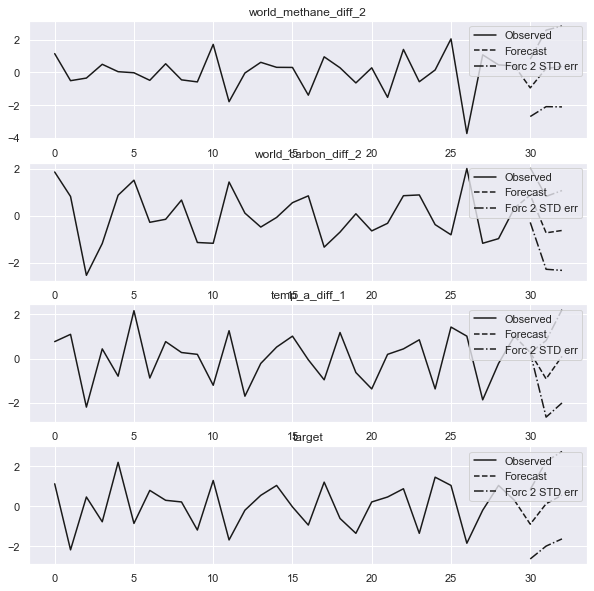

In [426]:

ts_model.plot_forecast(3);

In [427]:
forecast = ts_model.forecast(train.values, len(test))
df_forecast = ss.inverse_transform(forecast)
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')
for i in range(test.shape[1]):
    print(f'The test MSE on the {df_test.columns[i]} data is: {round(mean_squared_error(df_test.values[:, i], df_forecast[:, i]), 4)}')
df_forecast = pd.DataFrame(df_forecast)
df_forecast.index= df_test.index
df_forecast.columns = df_test.columns

The test MSE on the world_methane_diff_2 data is: 0.4491
The test MSE on the world_carbon_diff_2 data is: 0.6396
The test MSE on the temp_a_diff_1 data is: 0.4739
The test MSE on the target data is: 0.4813
The test MSE on the world_methane_diff_2 data is: 45908059786.0364
The test MSE on the world_carbon_diff_2 data is: 0.3088
The test MSE on the temp_a_diff_1 data is: 0.007
The test MSE on the target data is: 0.0071


0.0061328780517642244


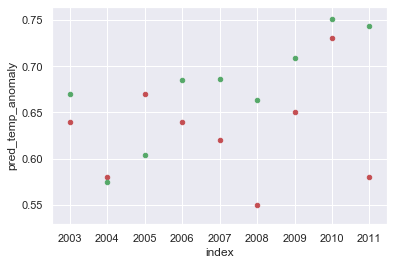

In [428]:
check = aggr.tail(12)
check = pd.DataFrame(check['temp_anomaly'])
check['temp_a_diff_est'] = df_forecast['temp_a_diff_1']
transf = [None]*12
transf[2] = 0.62
for i in range (3,12):
    transf[i] = transf[i-1]+check.iloc[i-1,1]
check['pred_temp_anomaly'] = transf
check = check.iloc[3:]
print(mean_squared_error(check['temp_anomaly'],check['pred_temp_anomaly']))
ax3 = check.reset_index().plot(kind='scatter',x='index', y='temp_anomaly', color='r')    
ax4 = check.reset_index().plot(kind='scatter',x='index', y='pred_temp_anomaly', color='g', ax=ax3) 

### Ridge 

In [429]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, shuffle=False)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [430]:
ridge_model = Ridge(alpha=8,fit_intercept=False,solver= 'saga')
ridge_model.fit(X_train_sc, y_train)
pred = ridge_model.predict(X_test_sc)
# Evaluate model using R2.
print(ridge_model.score(X_train_sc, y_train))
print(ridge_model.score(X_test_sc, y_test))
evaluate_model(ridge_model, X_test_sc, y_test)

0.43053402786709705
0.39274689581459676
R2 Score: 0.39274689581459676
MSE: 0.0036896698610305112
RMSE: 0.06074265273290681


0.0018977664731761133


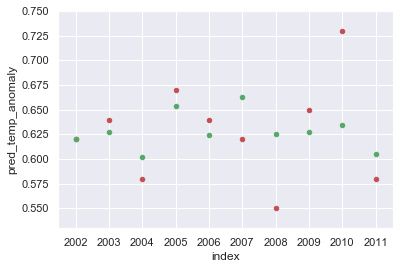

In [431]:
check = aggr.tail(12)
check = pd.DataFrame(check['temp_anomaly'])
hold = [None]*2
hold.extend(list(pred))
transf = [None]*12
transf[2] = 0.62
for i in range (3,12):
    transf[i] = transf[i-1]+pred[i-3]
check['pred_temp_anomaly'] = transf
check = check.iloc[2:]
print(mean_squared_error(check['temp_anomaly'],check['pred_temp_anomaly']))
ax3 = check.reset_index().plot(kind='scatter',x='index', y='temp_anomaly', color='r')    
ax4 = check.reset_index().plot(kind='scatter',x='index', y='pred_temp_anomaly', color='g', ax=ax3) 

### Lasso Predictions

In [432]:
l_alphas = np.logspace(-3, 0, 100)
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=5000, fit_intercept=False)
lasso_cv.fit(X_train_sc, y_train)
evaluate_model(lasso_cv, X_test_sc, y_test)
pred = lasso_cv.predict(X_test_sc)

R2 Score: 0.406738706859775
MSE: 0.0036046556171200083
RMSE: 0.06003878427416738


0.002129502684821172


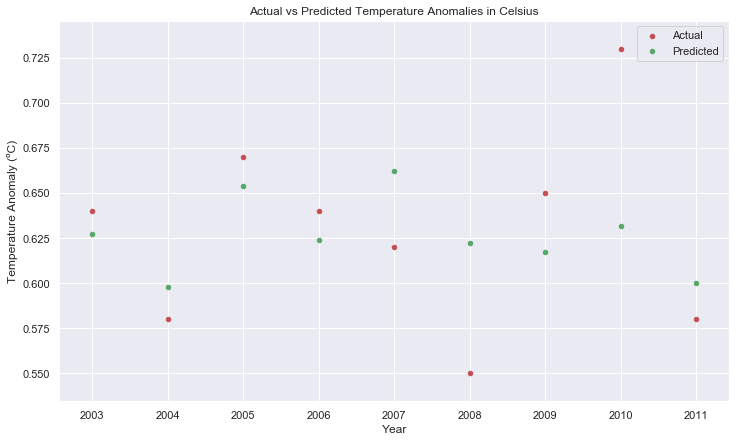

In [433]:
check = aggr.tail(12)
check = pd.DataFrame(check['temp_anomaly'])
hold = [None]*2
hold.extend(list(pred))
transf = [None]*12
transf[2] = 0.62
for i in range (3,12):
    transf[i] = transf[i-1]+pred[i-3]
check['pred_temp_anomaly'] = transf
check = check.iloc[3:]
print(mean_squared_error(check['temp_anomaly'],check['pred_temp_anomaly']))
ax3 = check.reset_index().plot(kind='scatter',x='index', y='temp_anomaly', color='r', figsize=(12,7))    
ax4 = check.reset_index().plot(kind='scatter',x='index', y='pred_temp_anomaly', color='g', ax=ax3) 
ax3.legend(labels = ['Actual', 'Predicted'])
ax3.set_title('Actual vs Predicted Temperature Anomalies in Celsius');
ax3.set_xlabel('Year')
ax3.set_ylabel('Temperature Anomaly (ºC)');

# OLM Temperature Anomaly Predictions

0.013982171816659932


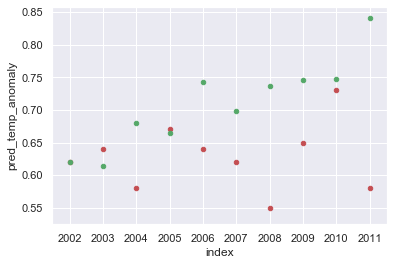

In [434]:
check = aggr.tail(12)
check = pd.DataFrame(check['temp_anomaly'])
transf = [None]*12
transf[2] = 0.62
for i in range (3,12):
    transf[i] = transf[i-1]+olm_results[i-2]
check['pred_temp_anomaly']= transf
check = check.dropna()
print(mean_squared_error(check['temp_anomaly'],check['pred_temp_anomaly']))
ax3 = check.reset_index().plot(kind='scatter',x='index', y='temp_anomaly', color='r')    
ax4 = check.reset_index().plot(kind='scatter',x='index', y='pred_temp_anomaly', color='g', ax=ax3) 

In [435]:
y_train, y_test = train_test_split(aggr['target'],
                                   random_state=42,
                                   shuffle = False)

In [436]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p},1,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(freq='AS-JAN',
                          endog = y_train.astype(float).dropna(), # endog = Y variable
                          order = (p,0,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},0,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,1,0)
The AIC for ARIMA(0,0,0) is: -32.34558873320566
Attempting to fit ARIMA(0,1,1)
The AIC for ARIMA(0,0,1) is: -45.8879110667728
Attempting to fit ARIMA(0,1,2)
The AIC for ARIMA(0,0,2) is: -44.12410612737298
Attempting to fit ARIMA(0,1,3)
The AIC for ARIMA(0,0,3) is: -42.1935963103754
Attempting to fit ARIMA(0,1,4)


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for ARIMA(0,0,4) is: nan
Attempting to fit ARIMA(1,1,0)
The AIC for ARIMA(1,0,0) is: -36.12237997854217
Attempting to fit ARIMA(1,1,1)
The AIC for ARIMA(1,0,1) is: -44.093617508761696
Attempting to fit ARIMA(1,1,2)
The AIC for ARIMA(1,0,2) is: -41.8854378254195
Attempting to fit ARIMA(1,1,3)


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Libr

The AIC for ARIMA(1,0,3) is: -40.12378488306351
Attempting to fit ARIMA(1,1,4)


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for ARIMA(1,0,4) is: -38.19173645069648
Attempting to fit ARIMA(2,1,0)
The AIC for ARIMA(2,0,0) is: -36.655642517582805
Attempting to fit ARIMA(2,1,1)
The AIC for ARIMA(2,0,1) is: -42.274895177975736
Attempting to fit ARIMA(2,1,2)


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for ARIMA(2,0,2) is: -40.093376662562235
Attempting to fit ARIMA(2,1,3)


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(2,0,3) is: -44.81885526666349
Attempting to fit ARIMA(2,1,4)
The AIC for ARIMA(2,0,4) is: -42.86340522656897
Attempting to fit ARIMA(3,1,0)
The AIC for ARIMA(3,0,0) is: -38.13964581114999
Attempting to fit ARIMA(3,1,1)
The AIC for ARIMA(3,0,1) is: -40.42403715396466
Attempting to fit ARIMA(3,1,2)


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The AIC for ARIMA(3,0,2) is: -38.269539664634436
Attempting to fit ARIMA(3,1,3)
The AIC for ARIMA(3,0,3) is: -42.93119651275356
Attempting to fit ARIMA(3,1,4)
Attempting to fit ARIMA(4,1,0)
The AIC for ARIMA(4,0,0) is: -36.865644602309544
Attempting to fit ARIMA(4,1,1)


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(4,0,1) is: -34.13608639050406
Attempting to fit ARIMA(4,1,2)
The AIC for ARIMA(4,0,2) is: -36.41985589000231
Attempting to fit ARIMA(4,1,3)
Attempting to fit ARIMA(4,1,4)


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,0,1).
This model has an AIC of -45.8879110667728.


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


/Library/Python/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


This model has an AIC of -45.8879110667728.


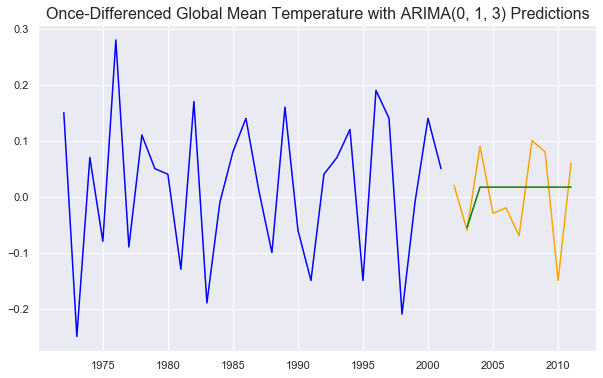

In [437]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (0,0,1))

# Fit ARIMA model.
arima = model.fit()
print(f'This model has an AIC of {arima.aic}.')
# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, pd.DataFrame(preds).shift(1), color = 'green')

plt.title(label = 'Once-Differenced Global Mean Temperature with ARIMA(0, 1, 3) Predictions', fontsize=16)
plt.show();

In [438]:
mean_squared_error(y_test,preds)

0.006863851090496362

0.003836206763429069


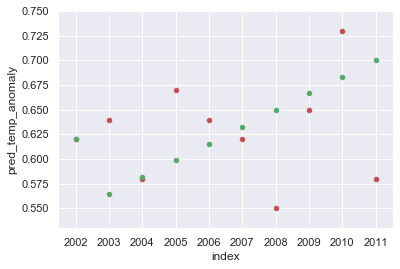

In [439]:
check = aggr.tail(12)
check = pd.DataFrame(check['temp_anomaly'])
transf = [None]*12
transf[2] = 0.62
for i in range (3,12):
    transf[i] = transf[i-1]+preds[i-3]
check['pred_temp_anomaly']= transf
check = check[2:]
print(mean_squared_error(check['temp_anomaly'],check['pred_temp_anomaly']))
ax3 = check.reset_index().plot(kind='scatter',x='index', y='temp_anomaly', color='r')    
ax4 = check.reset_index().plot(kind='scatter',x='index', y='pred_temp_anomaly', color='g', ax=ax3) 

## PCA + LASSO/Ridge

In [440]:
features = ['world_methane_diff_2', 'world_carbon_diff_2', 'temp_a_diff_2', 'temp_a_diff_1']
X= aggr[features]
y= aggr['target']
X_sc = ss.fit_transform(X)

In [441]:
pca = PCA()
X_pca = pca.fit(X_sc)

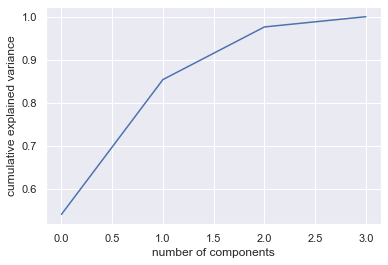

In [442]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [443]:
pf = PolynomialFeatures(degree = 1)
X_new = pf.fit_transform(X)
print(X_new.shape)
X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    y,
                                                    random_state = 42,
                                                    shuffle = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

(40, 5)


In [444]:
pipe = Pipeline([('pf', PolynomialFeatures()),
                 ('scaler', StandardScaler()),
                 ('pca', PCA()),
                 ('ridge', Ridge())])
pipe_params = { 'pf__degree' : [1,3],
                'pca__n_components' : [5,7,9,11],
                'ridge__alpha':[.0001,.5,1,3,5,9,13]}
pipe_gridsearch = GridSearchCV(pipe,
                                 pipe_params,
                                 cv = 5,
                                verbose = 1,
                                n_jobs=8)

In [445]:
pipe_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6)}

In [ ]:
pipe_gridsearch.best_score_

In [ ]:
pipe_gridsearch.best_params_

#### Confirm

In [446]:
pf = PolynomialFeatures(degree=1)
X_new = pf.fit_transform(X)

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    y,
                                                    random_state = 52,
                                                    shuffle = False)

In [448]:
pca = PCA(n_components = 5, random_state = 42)
pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)


### Ridge

In [449]:
ridge_model = Ridge(alpha=8, fit_intercept=False, solver='auto')
ridge_model.fit(Z_train, y_train)
pred = ridge_model.predict(Z_test)
print(ridge_model.score(Z_train, y_train))
evaluate_model(ridge_model, Z_test, y_test)

0.3751488782743291
R2 Score: 0.33350440490943667
MSE: 0.004049627235770264
RMSE: 0.06363668152701132


0.0027901565793524794


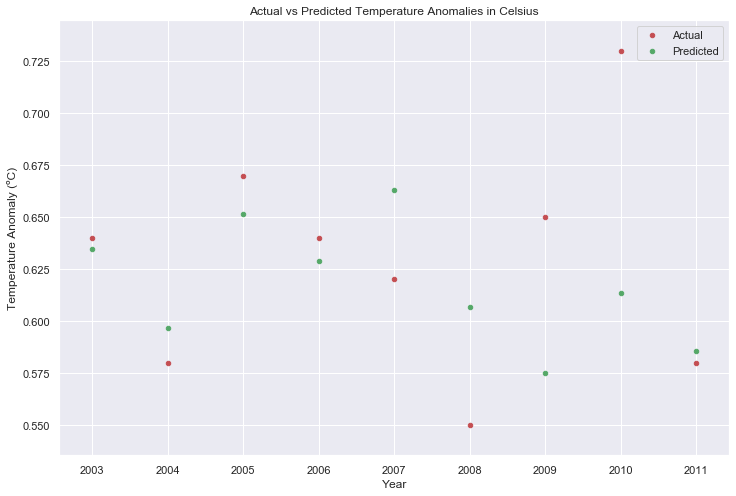

In [450]:
check = aggr.tail(12)
check = pd.DataFrame(check['temp_anomaly'])
hold = [None]*2
hold.extend(list(pred))
check['temp_a_diff_est'] = hold
transf = [None]*12
transf[2] = 0.62
for i in range (3,12):
    transf[i] = transf[i-1]+check.iloc[i-1,1]
check['pred_temp_anomaly'] = transf
check = check.iloc[3:]
print(mean_squared_error(check['temp_anomaly'],check['pred_temp_anomaly']))
ax3 = check.reset_index().plot(kind='scatter',x='index', y='temp_anomaly', color='r', figsize =(12,8))    
ax4 = check.reset_index().plot(kind='scatter',x='index', y='pred_temp_anomaly', color='g', ax=ax3) 
ax3.legend(labels = ['Actual', 'Predicted'])
ax3.set_title('Actual vs Predicted Temperature Anomalies in Celsius');
ax3.set_xlabel('Year')
ax3.set_ylabel('Temperature Anomaly (ºC)');

### LASSO

In [451]:
l_alphas = np.logspace(-3, 0, 100)
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=5000, fit_intercept=False)

lasso_cv.fit(Z_train, y_train)
pred = lasso_cv.predict(Z_test)
evaluate_model(lasso_cv, Z_test, y_test)


R2 Score: 0.29374128881102046
MSE: 0.004291227929184241
RMSE: 0.06550746468292175


0.0029874140870057493


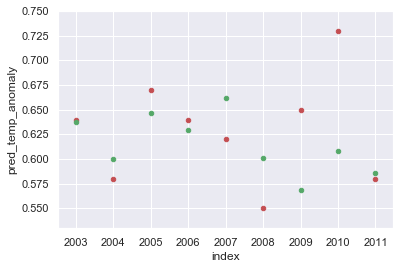

In [452]:
check = aggr.tail(12)
check = pd.DataFrame(check['temp_anomaly'])
hold = [None]*2
hold.extend(list(pred))
check['temp_a_diff_est'] = hold
transf = [None]*12
transf[2] = 0.62
for i in range (3,12):
    transf[i] = transf[i-1]+check.iloc[i-1,1]
check['pred_temp_anomaly'] = transf
check = check.iloc[3:]
print(mean_squared_error(check['temp_anomaly'],check['pred_temp_anomaly']))
ax3 = check.reset_index().plot(kind='scatter',x='index', y='temp_anomaly', color='r')    
ax4 = check.reset_index().plot(kind='scatter',x='index', y='pred_temp_anomaly', color='g', ax=ax3) 